In [52]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pickle
from glob import glob
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [53]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    

GPU is available


# MLP 

In [54]:
class MLPNet(nn.Module):
    def __init__(self, 
                 in_dim, # input dimension
                 out_dim, # output dimension
                 hidden_dim, # hidden dimension
                 num_layers # number of layers
                ):
        
        super(MLPNet, self).__init__()
        
        self.model = [nn.Linear(in_dim, hidden_dim), nn.ReLU()]
        
        for i in range(num_layers-2):
            self.model += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU()]
        
        self.model += [nn.Linear(hidden_dim, out_dim)]
        
        self.model = nn.Sequential(*self.model)
        
    def forward(self, inp):
        
        # Flatten the last two dimensions
        inp = inp.reshape(inp.shape[0], -1)
        
        out = self.model(inp)
        
        #bz x outputlength x 2
        return out.reshape(inp.shape[0], -1, 2)

In [3]:
# Autogressive vs. direct mapping
# Batch Norm? 

# Dataset

In [55]:
class ArgoverseDataset(torch.utils.data.Dataset):
    """Dataset class for Argoverse"""
    
    def __init__(self, 
                 data_path,
                 sample_indices):
        super(ArgoverseDataset, self).__init__()
        
        self.data_path = data_path
        self.sample_indices = sample_indices
        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        
        # Load one scene
        pkl_path = self.pkl_list[self.sample_indices[idx]]
        with open(pkl_path, 'rb') as f:
            scene = pickle.load(f)
            
        # the index of agent to be predicted 
        pred_id = np.where(scene["track_id"] == scene['agent_id'])[0][0]
        
        # input: p_in & v_in; output: p_out
        inp_scene = np.dstack([scene['p_in'], scene['v_in']])
        out_scene = np.dstack([scene['p_out'], scene['v_out']])
        
        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        # Normalize by vectors
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        out = (out_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        # Convert to float torch tensor
        return torch.from_numpy(inp).float(), torch.from_numpy(out[:,:2]).float()

In [5]:
# Try different ways of normalization
# Leverage other features. 

# Hyperparameter

In [6]:
# Grid/Random Search

In [56]:
# batch_size = 64
batch_size = 512
in_dim = 19*4
out_dim = 30*2
hidden_dim = 256 #128
num_layers = 3
learning_rate = 0.01
decay_rate = 0.95
num_epoch = 1000

# Data Loader

In [7]:
# train_path = "./train/train"

# # total number of scenes
# indices = np.arange(0, 1000)

# # train-valid split
# np.random.shuffle(indices)
# train_indices = indices[:900]
# valid_indices = indices[900:]

# # define datasets
# train_set = ArgoverseDataset(train_path, train_indices)
# valid_set = ArgoverseDataset(train_path, valid_indices)

# # create dataloaders
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
# valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [57]:
train_path = "../train/train"

# total number of scenes
indices = np.arange(0, 205942)

# train-valid split
np.random.shuffle(indices)
train_indices = indices[:180000]
valid_indices = indices[180000:]

# define datasets
train_set = ArgoverseDataset(train_path, train_indices)
valid_set = ArgoverseDataset(train_path, valid_indices)

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [26]:
for inp, out in train_loader:
    print(inp.shape)
    print(out.shape)
    break

torch.Size([512, 19, 2])
torch.Size([512, 30, 2])


# Model, Loss Function and Optimizer

In [58]:
# RNN, LSTM, 1dCNN, Transformer
model = MLPNet(in_dim = in_dim, 
               out_dim = out_dim,
               hidden_dim = hidden_dim, 
               num_layers = num_layers).to(device) # move model to gpu 

# Adaptive Moment Estimation computes adaptive learning rates for each parameter. 
# Compute the decaying averages of past and past squared gradients. 

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=decay_rate)  # stepwise learning rate decay
loss_fun = nn.MSELoss()

In [12]:
train_path = "../train/train/"
train_pkl_list = glob(os.path.join(train_path, '*'))
train_pkl_list.sort()

train_preds = []
for idx in range(3):
    with open(train_pkl_list[idx], 'rb') as f:
        train_sample = pickle.load(f)
        pred_id = np.where(train_sample["track_id"] == train_sample['agent_id'])[0][0]
        inp_scene = np.dstack([train_sample['p_in'], train_sample['v_in']])

        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        inp = torch.from_numpy(inp).float().to(device).unsqueeze(0)

        preds = model(inp).cpu().data.numpy()
        
        # De-Normalization ! 
        preds = preds * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
        train_preds.append(preds)

In [14]:
predictions = np.concatenate(train_preds).reshape(len(train_preds), -1).astype(int)

In [16]:
predictions.shape

(3, 60)

In [ ]:
predictions

# Training

In [59]:
len(train_loader)

352

In [60]:
def train_epoch(train_loader, model, optimizer, loss_function):
    train_mse = []
    for inp, tgt in tqdm(train_loader):
        inp = inp.to(device)
        tgt = tgt.to(device)
        
        #print("starting pred")
        pred = model(inp)
        #print("make pred")
        
        loss = loss_function(pred, tgt)
        train_mse.append(loss.item()) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_mse = round(np.sqrt(np.mean(train_mse)),5)
    return train_mse

def eval_epoch(valid_loader, model, loss_function):
    valid_mse = []
    preds = []
    trues = []
    with torch.no_grad():
        for inp, tgt in valid_loader:
            inp = inp.to(device)
            tgt = tgt.to(device)
            
            loss = 0
            pred = model(inp)
            loss = loss_function(pred, tgt)
            preds.append(pred.cpu().data.numpy())
            trues.append(tgt.cpu().data.numpy())
            valid_mse.append(loss.item())
            
        preds = np.concatenate(preds, axis = 0)  
        trues = np.concatenate(trues, axis = 0)  
        valid_mse = round(np.sqrt(np.mean(valid_mse)), 5)
    return valid_mse, preds, trues


In [14]:
# Learning Rate Decay
# Dropout
# L1/L2 Regulization

 44%|████▍     | 154/352 [01:49<01:26,  2.30it/s]


 88%|████████▊ | 308/352 [03:29<00:19,  2.26it/s]


100%|██████████| 352/352 [04:19<00:00,  1.36it/s]


Epoch 1 | T: 4.78 | Train RMSE: 0.11066 | Valid RMSE: 0.01871


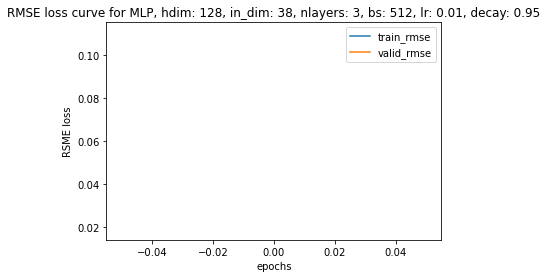

 44%|████▍     | 154/352 [01:17<01:24,  2.36it/s]


 88%|████████▊ | 308/352 [02:49<00:18,  2.35it/s]


100%|██████████| 352/352 [03:32<00:00,  1.65it/s]


Epoch 2 | T: 4.13 | Train RMSE: 0.01812 | Valid RMSE: 0.01793


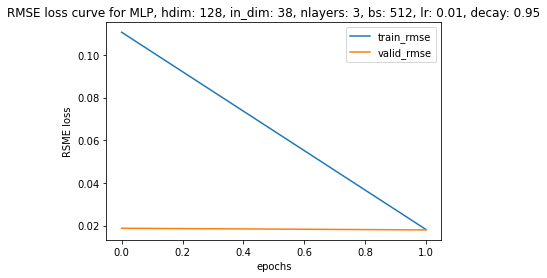

 44%|████▍     | 154/352 [01:23<01:29,  2.22it/s]


 88%|████████▊ | 308/352 [03:04<00:23,  1.84it/s]


100%|██████████| 352/352 [03:23<00:00,  1.73it/s]


Epoch 3 | T: 3.75 | Train RMSE: 0.01729 | Valid RMSE: 0.01728


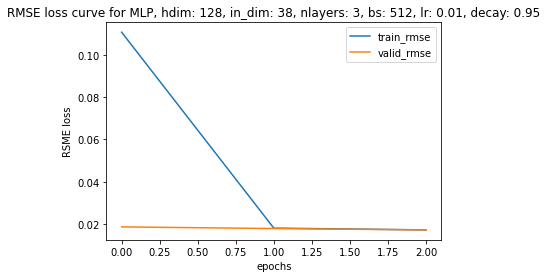

 44%|████▍     | 154/352 [01:59<01:24,  2.35it/s]


 88%|████████▊ | 308/352 [03:27<00:19,  2.29it/s]


100%|██████████| 352/352 [03:47<00:00,  1.55it/s]


Epoch 4 | T: 4.61 | Train RMSE: 0.01668 | Valid RMSE: 0.01661


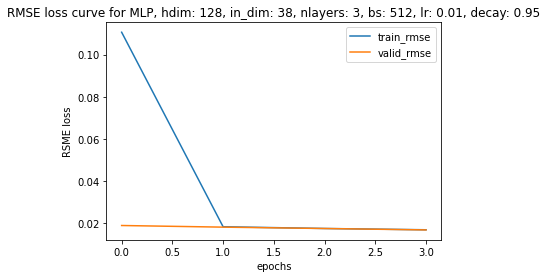

 44%|████▍     | 154/352 [01:52<01:27,  2.25it/s]


 88%|████████▊ | 308/352 [03:01<00:18,  2.34it/s]


100%|██████████| 352/352 [03:20<00:00,  1.76it/s]


Epoch 5 | T: 4.17 | Train RMSE: 0.01686 | Valid RMSE: 0.01725


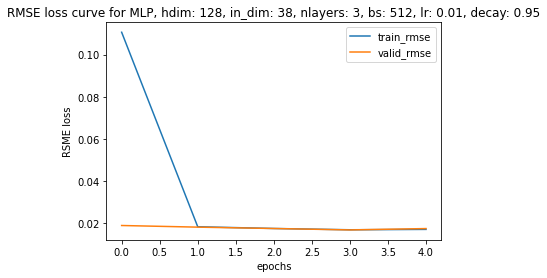

 44%|████▍     | 154/352 [01:55<01:23,  2.37it/s]


 88%|████████▊ | 308/352 [03:05<00:17,  2.48it/s]


100%|██████████| 352/352 [03:47<00:00,  1.55it/s]


Epoch 6 | T: 4.14 | Train RMSE: 0.01728 | Valid RMSE: 0.01575


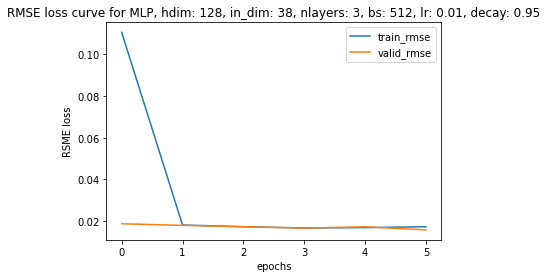

 44%|████▍     | 154/352 [02:03<01:21,  2.42it/s]


 88%|████████▊ | 308/352 [03:32<00:22,  1.94it/s]


100%|██████████| 352/352 [03:51<00:00,  1.52it/s]


Epoch 7 | T: 4.86 | Train RMSE: 0.01708 | Valid RMSE: 0.01625


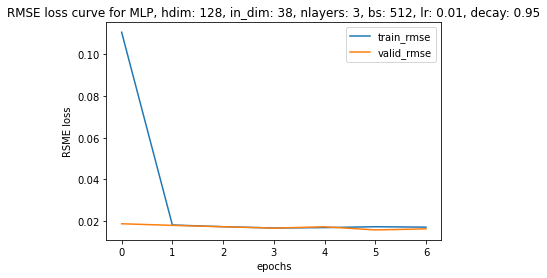

 44%|████▍     | 154/352 [01:34<01:26,  2.29it/s]


 88%|████████▊ | 308/352 [02:53<00:17,  2.54it/s]


100%|██████████| 352/352 [03:11<00:00,  1.84it/s]


Epoch 8 | T: 4.05 | Train RMSE: 0.01717 | Valid RMSE: 0.02350


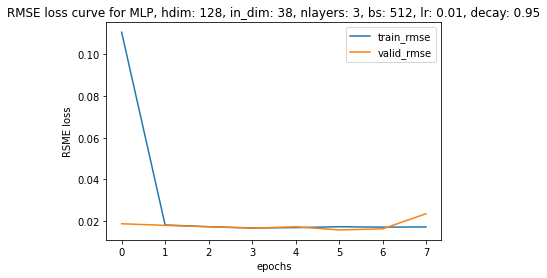

 44%|████▍     | 154/352 [01:47<01:26,  2.29it/s]


 88%|████████▊ | 308/352 [02:59<00:17,  2.54it/s]


100%|██████████| 352/352 [03:38<00:00,  1.61it/s]


Epoch 9 | T: 4.01 | Train RMSE: 0.01538 | Valid RMSE: 0.01219


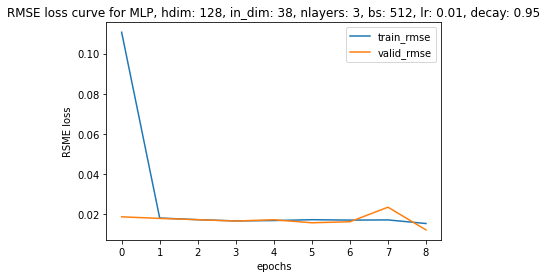

 44%|████▍     | 154/352 [02:03<01:28,  2.24it/s]


 88%|████████▊ | 308/352 [03:11<00:18,  2.39it/s]


100%|██████████| 352/352 [03:47<00:00,  1.55it/s]


Epoch 10 | T: 4.15 | Train RMSE: 0.01467 | Valid RMSE: 0.01190


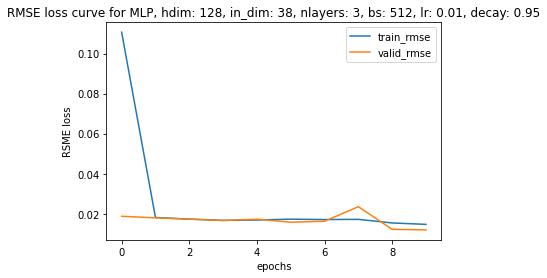

 44%|████▍     | 154/352 [02:14<01:35,  2.07it/s]


 88%|████████▊ | 308/352 [03:32<00:17,  2.52it/s]


100%|██████████| 352/352 [03:50<00:00,  1.53it/s]


Epoch 11 | T: 4.66 | Train RMSE: 0.01460 | Valid RMSE: 0.01460


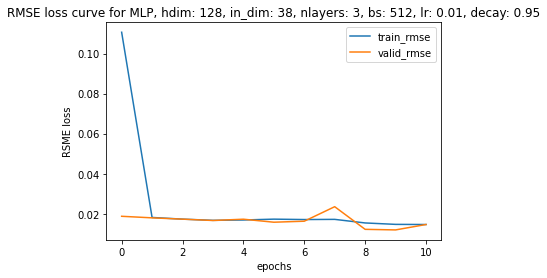

 44%|████▍     | 154/352 [01:55<01:29,  2.20it/s]


 88%|████████▊ | 308/352 [03:04<00:18,  2.37it/s]


100%|██████████| 352/352 [03:22<00:00,  1.74it/s]


Epoch 12 | T: 4.10 | Train RMSE: 0.01374 | Valid RMSE: 0.01001


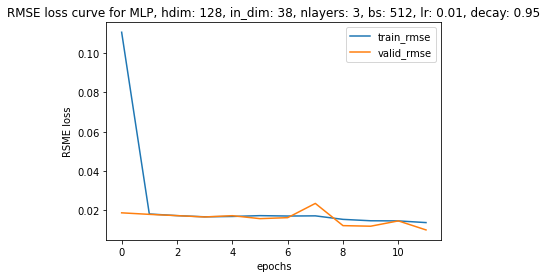

 44%|████▍     | 154/352 [02:05<01:30,  2.18it/s]


 88%|████████▊ | 308/352 [03:12<00:18,  2.43it/s]


100%|██████████| 352/352 [03:55<00:00,  1.50it/s]


Epoch 13 | T: 4.28 | Train RMSE: 0.01270 | Valid RMSE: 0.01183


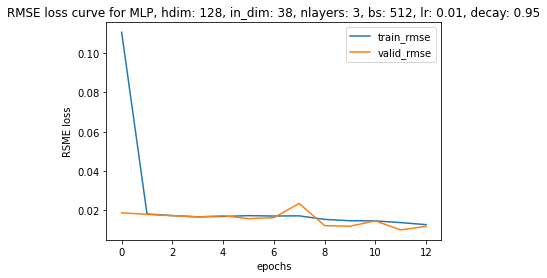

 44%|████▍     | 154/352 [02:02<01:24,  2.35it/s]


 88%|████████▊ | 308/352 [03:29<00:19,  2.26it/s]


100%|██████████| 352/352 [03:47<00:00,  1.55it/s]


Epoch 14 | T: 4.52 | Train RMSE: 0.01234 | Valid RMSE: 0.01218


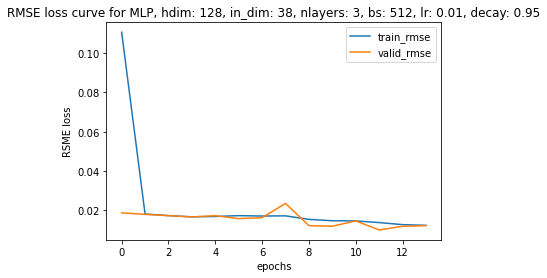

 44%|████▍     | 154/352 [01:55<01:22,  2.39it/s]


 88%|████████▊ | 308/352 [03:11<00:19,  2.29it/s]


100%|██████████| 352/352 [03:29<00:00,  1.68it/s]


Epoch 15 | T: 4.17 | Train RMSE: 0.01189 | Valid RMSE: 0.00904


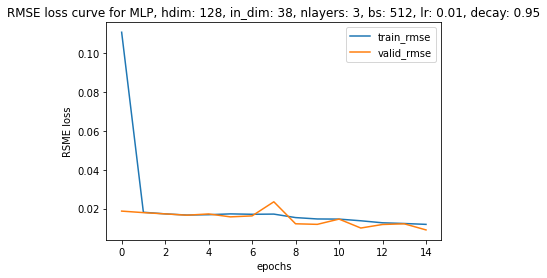

 44%|████▍     | 154/352 [02:07<01:35,  2.07it/s]


 88%|████████▊ | 308/352 [03:18<00:19,  2.28it/s]


100%|██████████| 352/352 [03:54<00:00,  1.50it/s]


Epoch 16 | T: 4.26 | Train RMSE: 0.01135 | Valid RMSE: 0.00917


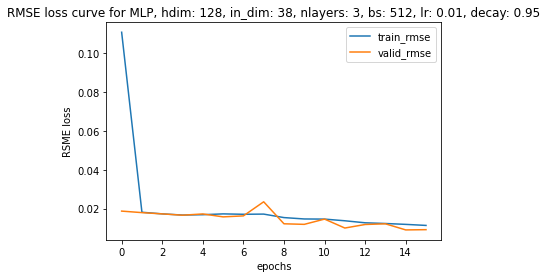

 44%|████▍     | 154/352 [02:17<02:07,  1.55it/s]


 88%|████████▊ | 308/352 [03:36<00:19,  2.26it/s]


100%|██████████| 352/352 [03:55<00:00,  1.49it/s]


Epoch 17 | T: 4.65 | Train RMSE: 0.01094 | Valid RMSE: 0.00879


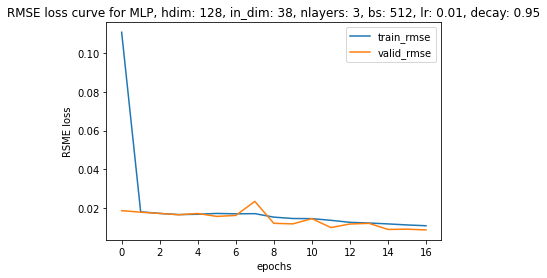

 44%|████▍     | 154/352 [02:03<01:32,  2.15it/s]


 88%|████████▊ | 308/352 [03:16<00:19,  2.28it/s]


100%|██████████| 352/352 [03:52<00:00,  1.51it/s]


Epoch 18 | T: 4.26 | Train RMSE: 0.01089 | Valid RMSE: 0.01051


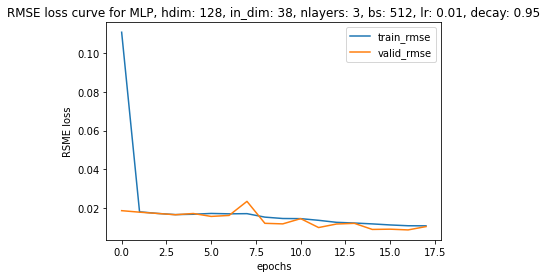

 44%|████▍     | 154/352 [02:05<01:29,  2.21it/s]


 88%|████████▊ | 308/352 [03:32<00:22,  1.97it/s]


100%|██████████| 352/352 [03:52<00:00,  1.52it/s]


Epoch 19 | T: 4.24 | Train RMSE: 0.01023 | Valid RMSE: 0.01110


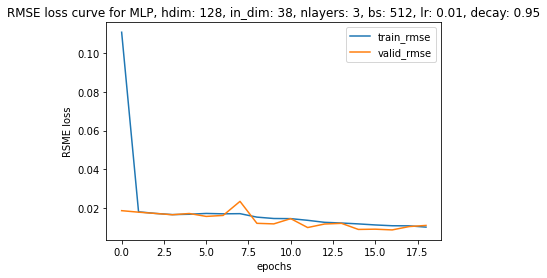

 44%|████▍     | 154/352 [02:20<02:28,  1.34it/s]


 88%|████████▊ | 308/352 [03:37<00:20,  2.17it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


Epoch 20 | T: 4.57 | Train RMSE: 0.00992 | Valid RMSE: 0.01003


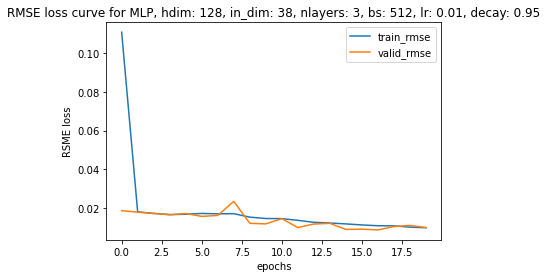

 44%|████▍     | 154/352 [02:07<01:29,  2.20it/s]


 88%|████████▊ | 308/352 [03:20<00:18,  2.36it/s]


100%|██████████| 352/352 [03:52<00:00,  1.51it/s]


Epoch 21 | T: 4.23 | Train RMSE: 0.00986 | Valid RMSE: 0.01085


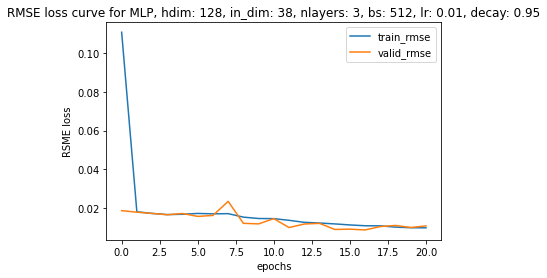

 44%|████▍     | 154/352 [02:20<04:31,  1.37s/it]


 88%|████████▊ | 308/352 [03:36<00:18,  2.40it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


Epoch 22 | T: 4.64 | Train RMSE: 0.00959 | Valid RMSE: 0.00918


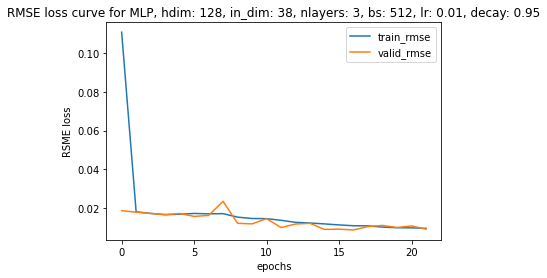

 44%|████▍     | 154/352 [02:04<01:28,  2.23it/s]


 88%|████████▊ | 308/352 [03:14<00:19,  2.27it/s]


100%|██████████| 352/352 [03:32<00:00,  1.66it/s]


Epoch 23 | T: 4.27 | Train RMSE: 0.00934 | Valid RMSE: 0.00741


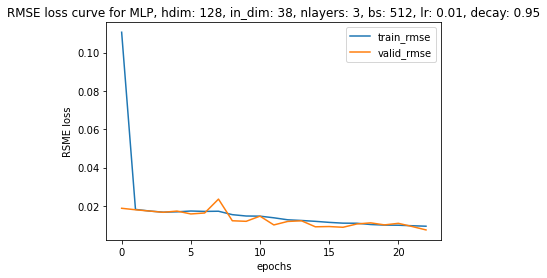

 44%|████▍     | 154/352 [02:04<01:27,  2.26it/s]


 88%|████████▊ | 308/352 [03:15<00:18,  2.40it/s]


100%|██████████| 352/352 [03:50<00:00,  1.53it/s]


Epoch 24 | T: 4.21 | Train RMSE: 0.00887 | Valid RMSE: 0.00868


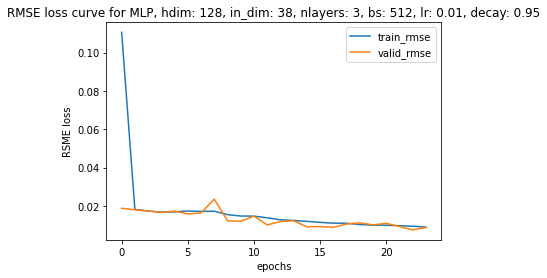

 44%|████▍     | 154/352 [02:07<01:32,  2.13it/s]


 88%|████████▊ | 308/352 [03:35<00:19,  2.22it/s]


100%|██████████| 352/352 [03:54<00:00,  1.50it/s]


Epoch 25 | T: 4.58 | Train RMSE: 0.00886 | Valid RMSE: 0.00841


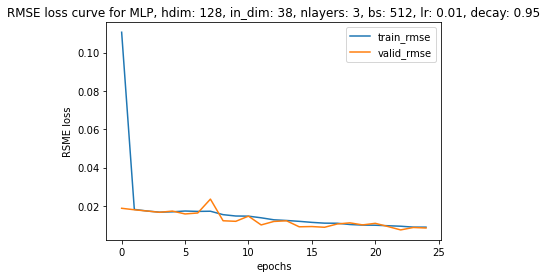

 44%|████▍     | 154/352 [02:07<01:31,  2.16it/s]


 88%|████████▊ | 308/352 [03:20<00:20,  2.18it/s]


100%|██████████| 352/352 [03:55<00:00,  1.50it/s]


Epoch 26 | T: 4.29 | Train RMSE: 0.00843 | Valid RMSE: 0.01212


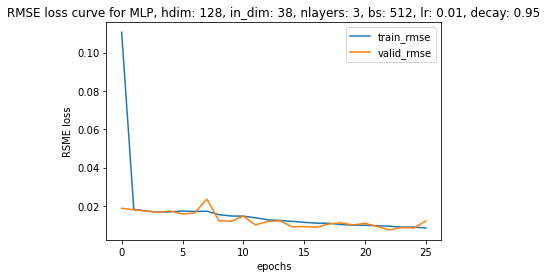

 44%|████▍     | 154/352 [02:08<01:28,  2.25it/s]


 88%|████████▊ | 308/352 [03:33<00:19,  2.23it/s]


100%|██████████| 352/352 [03:53<00:00,  1.51it/s]


Epoch 27 | T: 4.24 | Train RMSE: 0.00819 | Valid RMSE: 0.00692


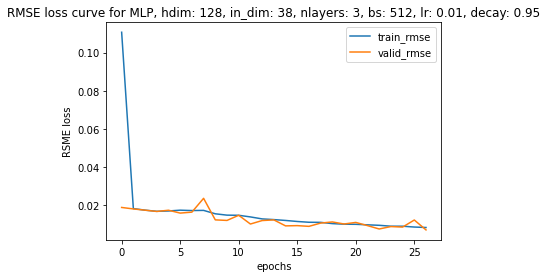

 44%|████▍     | 154/352 [02:23<01:36,  2.06it/s]


 88%|████████▊ | 308/352 [03:36<00:20,  2.18it/s]


100%|██████████| 352/352 [03:55<00:00,  1.49it/s]


Epoch 28 | T: 4.59 | Train RMSE: 0.00814 | Valid RMSE: 0.00761


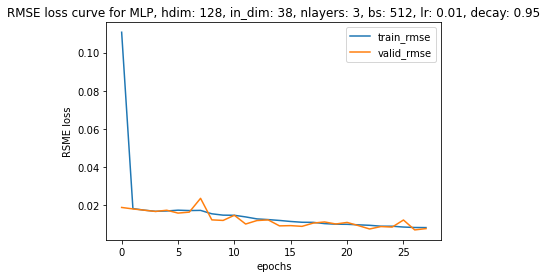

 44%|████▍     | 154/352 [02:05<01:26,  2.29it/s]


 88%|████████▊ | 308/352 [03:19<00:18,  2.41it/s]


100%|██████████| 352/352 [03:50<00:00,  1.53it/s]


Epoch 29 | T: 4.21 | Train RMSE: 0.00788 | Valid RMSE: 0.00706


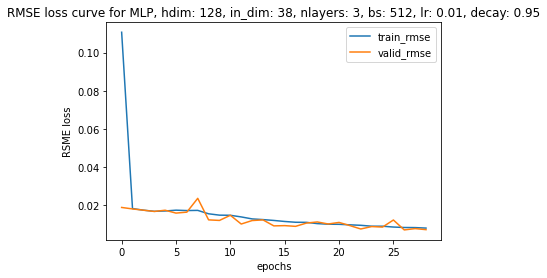

 44%|████▍     | 154/352 [02:06<01:28,  2.24it/s]


 88%|████████▊ | 308/352 [03:32<00:18,  2.36it/s]


100%|██████████| 352/352 [03:51<00:00,  1.52it/s]


Epoch 30 | T: 4.22 | Train RMSE: 0.00783 | Valid RMSE: 0.00776


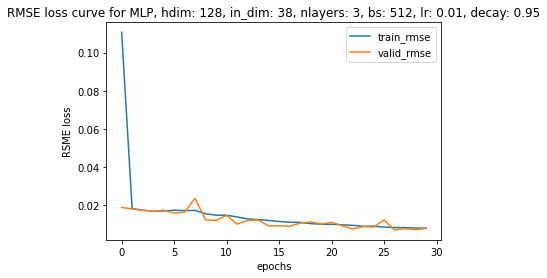

 44%|████▍     | 154/352 [02:22<21:05,  6.39s/it]


 88%|████████▊ | 308/352 [03:33<00:19,  2.28it/s]


100%|██████████| 352/352 [03:51<00:00,  1.52it/s]


Epoch 31 | T: 4.45 | Train RMSE: 0.00763 | Valid RMSE: 0.00921


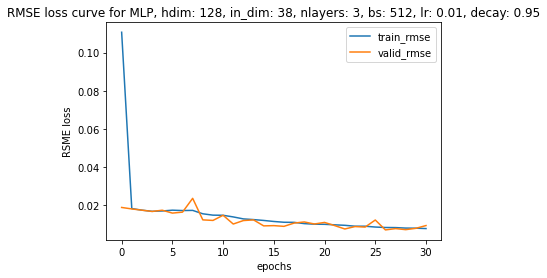

 44%|████▍     | 154/352 [02:06<01:42,  1.94it/s]


 88%|████████▊ | 308/352 [03:21<00:17,  2.45it/s]


100%|██████████| 352/352 [03:51<00:00,  1.52it/s]


Epoch 32 | T: 4.22 | Train RMSE: 0.00739 | Valid RMSE: 0.00831


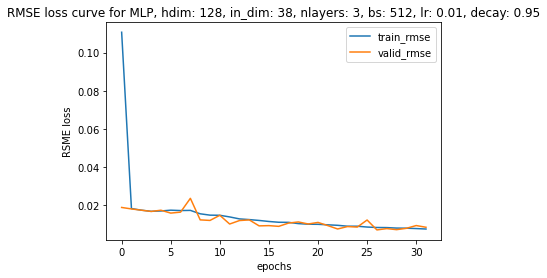

 44%|████▍     | 154/352 [02:01<01:26,  2.28it/s]


 88%|████████▊ | 308/352 [03:18<00:19,  2.26it/s]


100%|██████████| 352/352 [03:49<00:00,  1.53it/s]


Epoch 33 | T: 4.19 | Train RMSE: 0.00709 | Valid RMSE: 0.00750


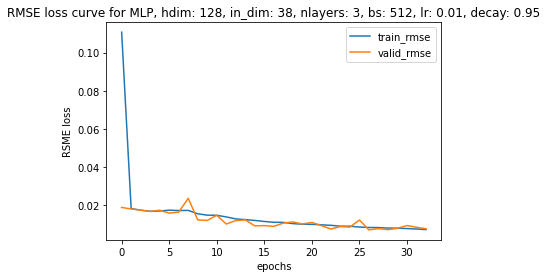

 44%|████▍     | 154/352 [01:55<01:34,  2.10it/s]


 88%|████████▊ | 308/352 [03:33<00:20,  2.11it/s]


100%|██████████| 352/352 [03:53<00:00,  1.51it/s]


Epoch 34 | T: 4.50 | Train RMSE: 0.00710 | Valid RMSE: 0.00812


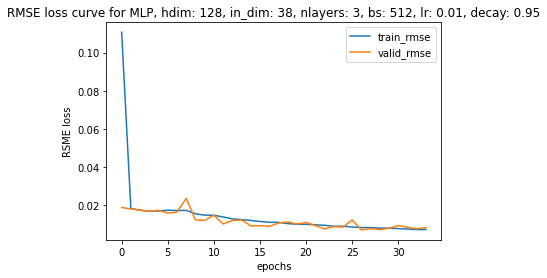

 44%|████▍     | 154/352 [01:34<01:35,  2.08it/s]


 88%|████████▊ | 308/352 [03:17<00:16,  2.64it/s]


100%|██████████| 352/352 [03:36<00:00,  1.62it/s]


Epoch 35 | T: 4.17 | Train RMSE: 0.00677 | Valid RMSE: 0.00730


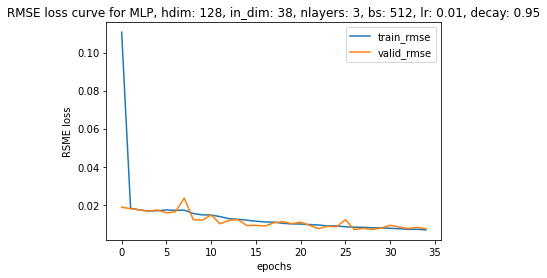

 44%|████▍     | 154/352 [01:54<16:21,  4.96s/it]


 88%|████████▊ | 308/352 [03:17<00:19,  2.25it/s]


100%|██████████| 352/352 [03:49<00:00,  1.54it/s]


Epoch 36 | T: 4.21 | Train RMSE: 0.00657 | Valid RMSE: 0.00665


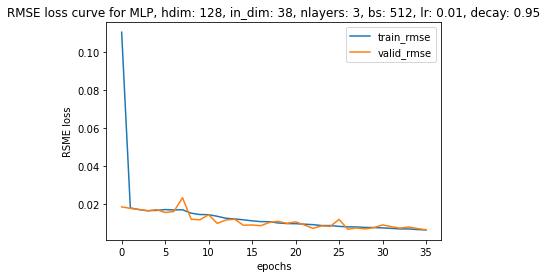

 44%|████▍     | 154/352 [01:51<01:40,  1.96it/s]


 88%|████████▊ | 308/352 [03:15<00:17,  2.47it/s]


100%|██████████| 352/352 [03:50<00:00,  1.53it/s]


Epoch 37 | T: 4.20 | Train RMSE: 0.00651 | Valid RMSE: 0.00620


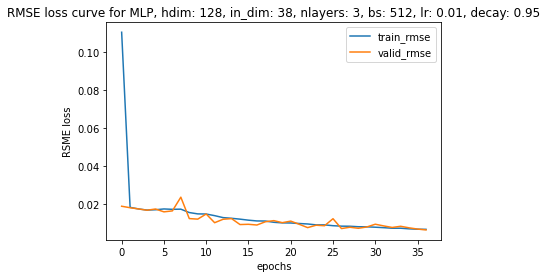

 44%|████▍     | 154/352 [01:49<01:28,  2.23it/s]


 88%|████████▊ | 308/352 [03:30<00:20,  2.15it/s]


100%|██████████| 352/352 [03:50<00:00,  1.53it/s]


Epoch 38 | T: 4.46 | Train RMSE: 0.00637 | Valid RMSE: 0.00547


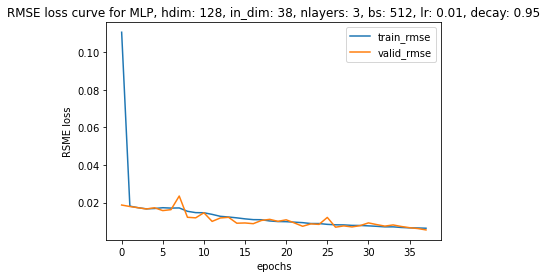

 44%|████▍     | 154/352 [01:34<01:25,  2.31it/s]


 88%|████████▊ | 308/352 [03:13<00:19,  2.30it/s]


100%|██████████| 352/352 [03:31<00:00,  1.66it/s]


Epoch 39 | T: 4.20 | Train RMSE: 0.00629 | Valid RMSE: 0.00553


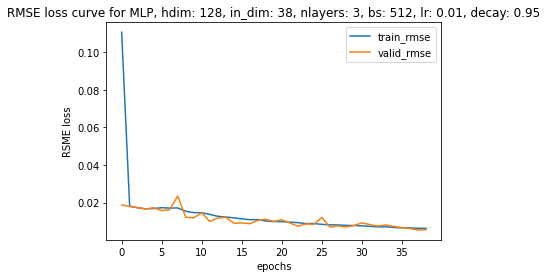

 44%|████▍     | 154/352 [01:50<04:23,  1.33s/it]


 88%|████████▊ | 308/352 [03:08<00:18,  2.32it/s]


100%|██████████| 352/352 [03:27<00:00,  1.70it/s]


Epoch 40 | T: 4.22 | Train RMSE: 0.00610 | Valid RMSE: 0.00630


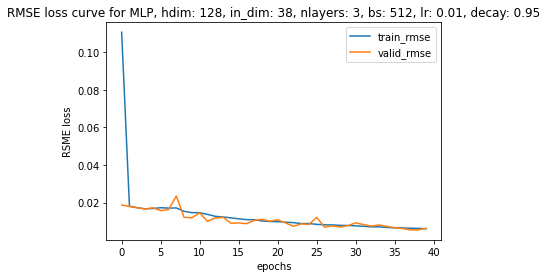

 44%|████▍     | 154/352 [01:50<01:35,  2.08it/s]


 88%|████████▊ | 308/352 [03:06<00:18,  2.34it/s]


100%|██████████| 352/352 [03:52<00:00,  1.52it/s]


Epoch 41 | T: 4.23 | Train RMSE: 0.00603 | Valid RMSE: 0.00628


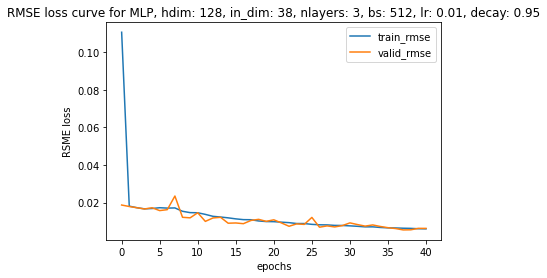

 44%|████▍     | 154/352 [01:47<01:30,  2.20it/s]


 88%|████████▊ | 308/352 [03:03<00:17,  2.46it/s]


100%|██████████| 352/352 [03:51<00:00,  1.52it/s]


Epoch 42 | T: 4.64 | Train RMSE: 0.00599 | Valid RMSE: 0.00652


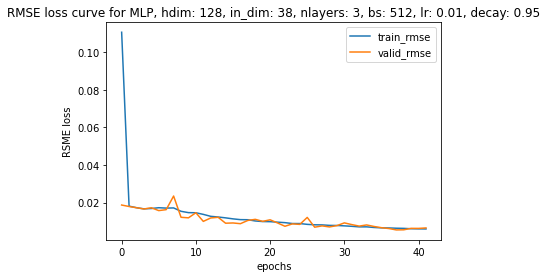

 44%|████▍     | 154/352 [01:22<01:26,  2.28it/s]


 88%|████████▊ | 308/352 [03:02<00:18,  2.43it/s]


100%|██████████| 352/352 [03:22<00:00,  1.74it/s]


Epoch 43 | T: 4.19 | Train RMSE: 0.00584 | Valid RMSE: 0.00581


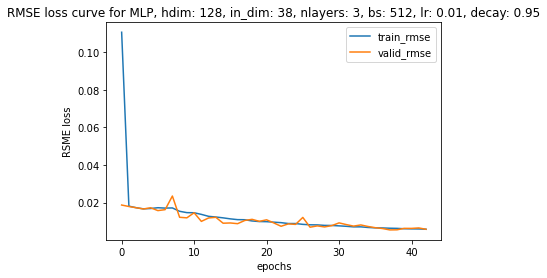

 44%|████▍     | 154/352 [01:40<01:29,  2.21it/s]


 88%|████████▊ | 308/352 [02:59<00:18,  2.35it/s]


100%|██████████| 352/352 [03:49<00:00,  1.54it/s]


Epoch 44 | T: 4.18 | Train RMSE: 0.00583 | Valid RMSE: 0.00581


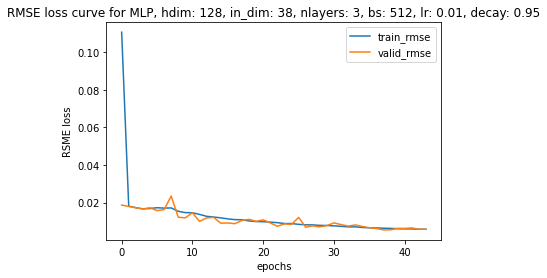

 44%|████▍     | 154/352 [01:41<01:30,  2.18it/s]


 88%|████████▊ | 308/352 [02:59<00:16,  2.65it/s]


100%|██████████| 352/352 [03:48<00:00,  1.54it/s]


Epoch 45 | T: 4.57 | Train RMSE: 0.00580 | Valid RMSE: 0.00577


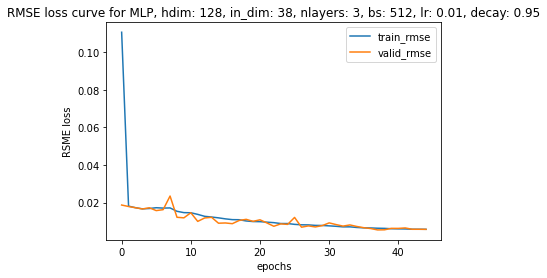

 44%|████▍     | 154/352 [01:18<01:24,  2.33it/s]


 88%|████████▊ | 308/352 [03:03<00:21,  2.03it/s]


100%|██████████| 352/352 [03:22<00:00,  1.74it/s]


Epoch 46 | T: 4.19 | Train RMSE: 0.00575 | Valid RMSE: 0.00646


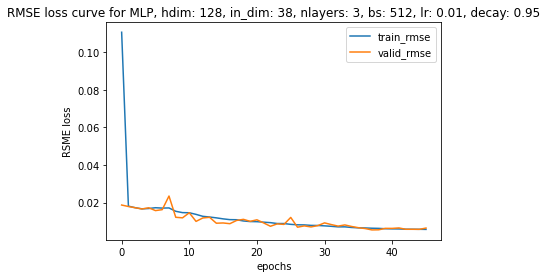

 44%|████▍     | 154/352 [01:35<03:41,  1.12s/it]


 88%|████████▊ | 308/352 [02:59<00:17,  2.48it/s]


100%|██████████| 352/352 [03:16<00:00,  1.79it/s]


Epoch 47 | T: 4.14 | Train RMSE: 0.00565 | Valid RMSE: 0.00543


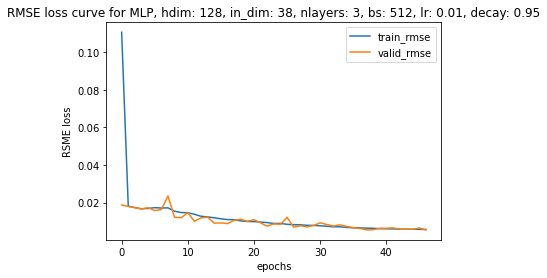

 44%|████▍     | 154/352 [01:43<01:29,  2.21it/s]


 88%|████████▊ | 308/352 [02:59<00:17,  2.51it/s]


100%|██████████| 352/352 [03:46<00:00,  1.56it/s]


Epoch 48 | T: 4.14 | Train RMSE: 0.00565 | Valid RMSE: 0.00558


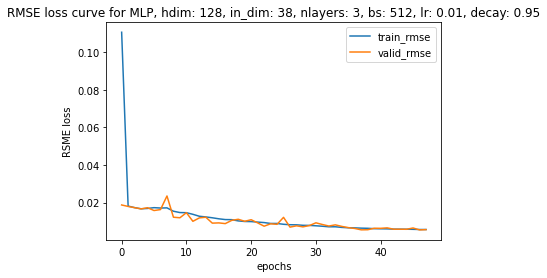

 44%|████▍     | 154/352 [01:51<01:25,  2.32it/s]


 88%|████████▊ | 308/352 [03:28<02:00,  2.74s/it]


100%|██████████| 352/352 [03:47<00:00,  1.55it/s]


Epoch 49 | T: 4.74 | Train RMSE: 0.00558 | Valid RMSE: 0.00575


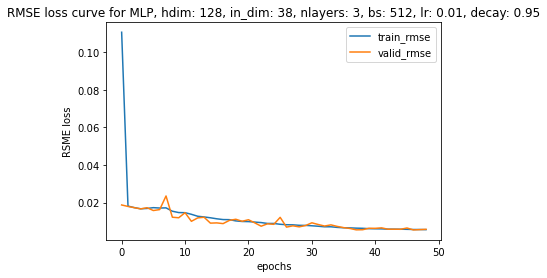

 44%|████▍     | 154/352 [01:33<01:31,  2.16it/s]


 88%|████████▊ | 308/352 [02:54<00:19,  2.26it/s]


100%|██████████| 352/352 [03:13<00:00,  1.82it/s]


Epoch 50 | T: 4.16 | Train RMSE: 0.00560 | Valid RMSE: 0.00545


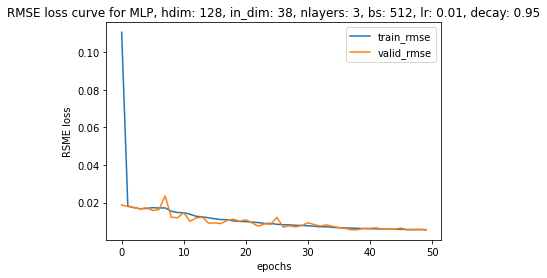

 44%|████▍     | 154/352 [01:44<01:34,  2.09it/s]


 88%|████████▊ | 308/352 [03:00<00:17,  2.46it/s]


100%|██████████| 352/352 [03:46<00:00,  1.56it/s]


Epoch 51 | T: 4.15 | Train RMSE: 0.00554 | Valid RMSE: 0.00544


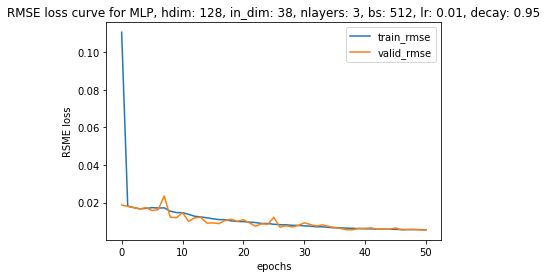

 44%|████▍     | 154/352 [01:52<01:31,  2.17it/s]


 88%|████████▊ | 308/352 [03:26<00:19,  2.22it/s]


100%|██████████| 352/352 [03:45<00:00,  1.56it/s]


Epoch 52 | T: 4.71 | Train RMSE: 0.00552 | Valid RMSE: 0.00537


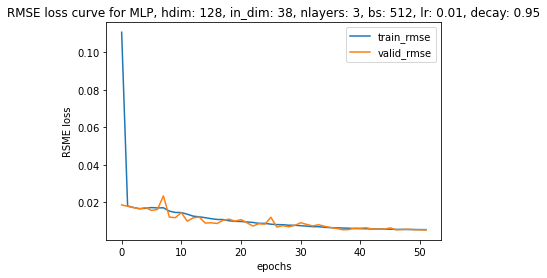

 44%|████▍     | 154/352 [01:40<01:33,  2.11it/s]


 88%|████████▊ | 308/352 [03:00<00:20,  2.20it/s]


100%|██████████| 352/352 [03:18<00:00,  1.77it/s]


Epoch 53 | T: 4.13 | Train RMSE: 0.00546 | Valid RMSE: 0.00539


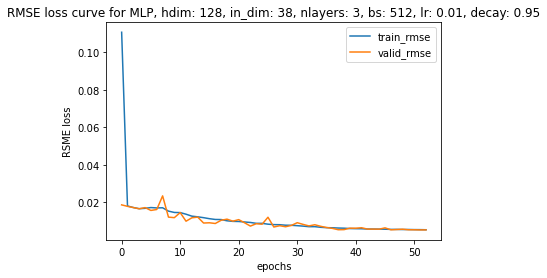

 44%|████▍     | 154/352 [01:50<01:38,  2.02it/s]


 88%|████████▊ | 308/352 [03:07<00:18,  2.38it/s]


100%|██████████| 352/352 [03:46<00:00,  1.55it/s]


Epoch 54 | T: 4.17 | Train RMSE: 0.00548 | Valid RMSE: 0.00542


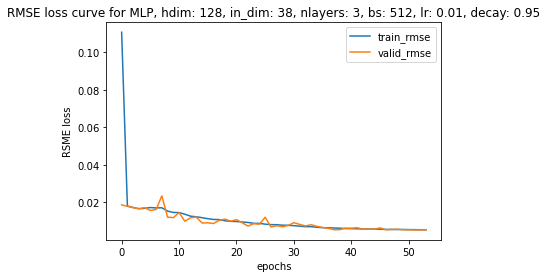

 44%|████▍     | 154/352 [02:00<01:25,  2.30it/s]


 88%|████████▊ | 308/352 [03:29<00:21,  2.02it/s]


100%|██████████| 352/352 [03:49<00:00,  1.53it/s]


Epoch 55 | T: 4.74 | Train RMSE: 0.00544 | Valid RMSE: 0.00530


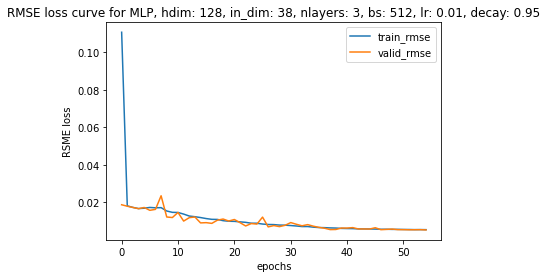

 44%|████▍     | 154/352 [01:43<01:34,  2.09it/s]


 88%|████████▊ | 308/352 [03:02<00:20,  2.12it/s]


100%|██████████| 352/352 [03:46<00:00,  1.55it/s]


Epoch 56 | T: 4.17 | Train RMSE: 0.00544 | Valid RMSE: 0.00603


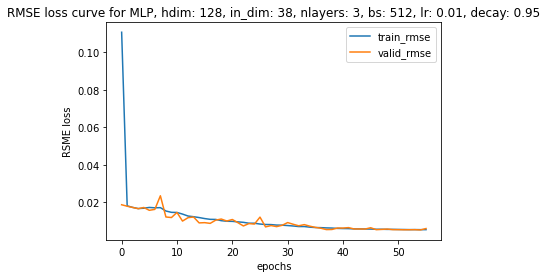

 44%|████▍     | 154/352 [01:53<01:31,  2.18it/s]


 88%|████████▊ | 308/352 [03:25<02:43,  3.72s/it]


100%|██████████| 352/352 [03:45<00:00,  1.56it/s]


Epoch 57 | T: 4.13 | Train RMSE: 0.00545 | Valid RMSE: 0.00576


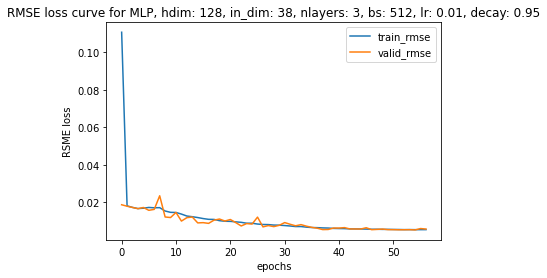

 44%|████▍     | 154/352 [02:14<01:34,  2.09it/s]


 88%|████████▊ | 308/352 [03:35<00:20,  2.15it/s]


100%|██████████| 352/352 [03:54<00:00,  1.50it/s]


Epoch 58 | T: 4.78 | Train RMSE: 0.00540 | Valid RMSE: 0.00574


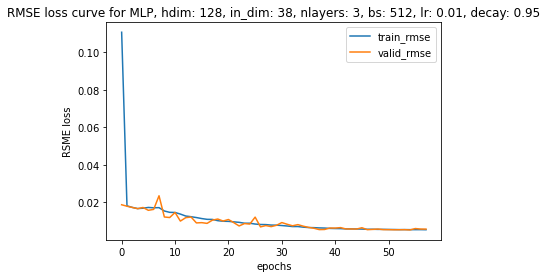

 44%|████▍     | 154/352 [01:48<01:37,  2.03it/s]


 88%|████████▊ | 308/352 [03:02<00:17,  2.50it/s]


100%|██████████| 352/352 [03:44<00:00,  1.57it/s]


Epoch 59 | T: 4.12 | Train RMSE: 0.00537 | Valid RMSE: 0.00538


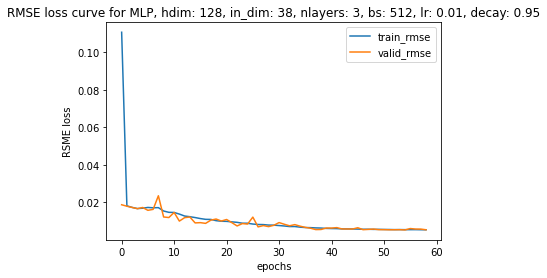

 44%|████▍     | 154/352 [02:01<01:35,  2.08it/s]


 88%|████████▊ | 308/352 [03:29<00:25,  1.75it/s]


100%|██████████| 352/352 [03:48<00:00,  1.54it/s]


Epoch 60 | T: 4.79 | Train RMSE: 0.00534 | Valid RMSE: 0.00567


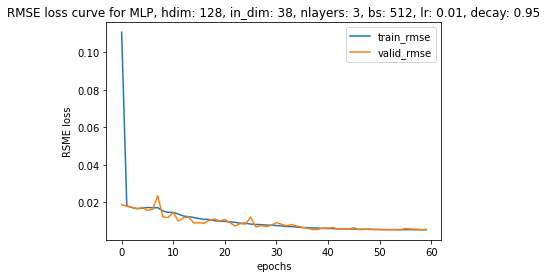

 44%|████▍     | 154/352 [01:39<01:29,  2.22it/s]


 88%|████████▊ | 308/352 [02:58<00:19,  2.27it/s]


100%|██████████| 352/352 [03:16<00:00,  1.79it/s]


Epoch 61 | T: 4.17 | Train RMSE: 0.00538 | Valid RMSE: 0.00562


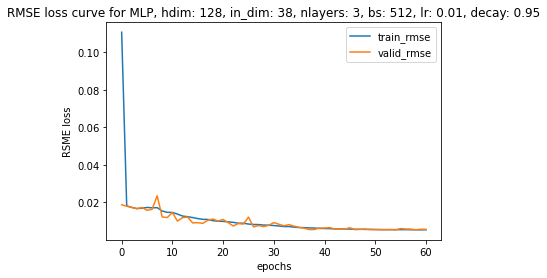

 44%|████▍     | 154/352 [01:47<01:33,  2.13it/s]


 88%|████████▊ | 308/352 [03:02<00:18,  2.44it/s]


100%|██████████| 352/352 [03:46<00:00,  1.56it/s]


Epoch 62 | T: 4.16 | Train RMSE: 0.00538 | Valid RMSE: 0.00542


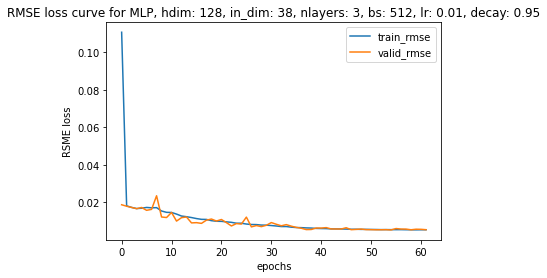

 44%|████▍     | 154/352 [01:55<01:26,  2.30it/s]


 88%|████████▊ | 308/352 [03:26<00:20,  2.19it/s]


100%|██████████| 352/352 [03:45<00:00,  1.56it/s]


Epoch 63 | T: 4.69 | Train RMSE: 0.00535 | Valid RMSE: 0.00522


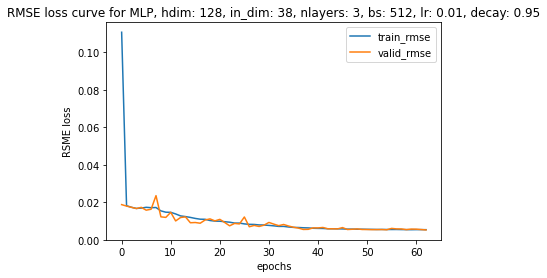

 44%|████▍     | 154/352 [01:39<01:30,  2.19it/s]


 88%|████████▊ | 308/352 [02:58<00:20,  2.17it/s]


100%|██████████| 352/352 [03:17<00:00,  1.78it/s]


Epoch 64 | T: 4.13 | Train RMSE: 0.00534 | Valid RMSE: 0.00537


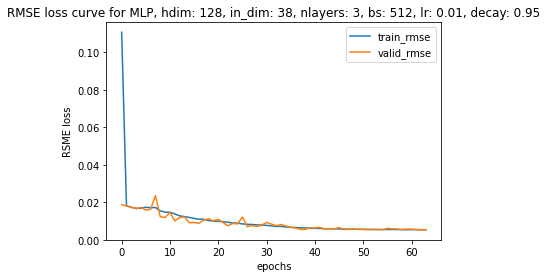

 44%|████▍     | 154/352 [01:48<01:30,  2.19it/s]


 88%|████████▊ | 308/352 [03:02<00:17,  2.56it/s]


100%|██████████| 352/352 [03:41<00:00,  1.59it/s]


Epoch 65 | T: 4.06 | Train RMSE: 0.00531 | Valid RMSE: 0.00565


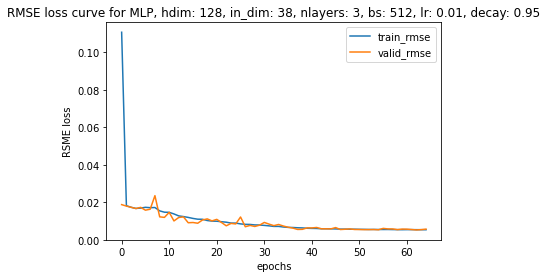

 44%|████▍     | 154/352 [02:00<01:26,  2.29it/s]


 88%|████████▊ | 308/352 [03:31<00:32,  1.34it/s]


100%|██████████| 352/352 [03:51<00:00,  1.52it/s]


Epoch 66 | T: 4.81 | Train RMSE: 0.00531 | Valid RMSE: 0.00520


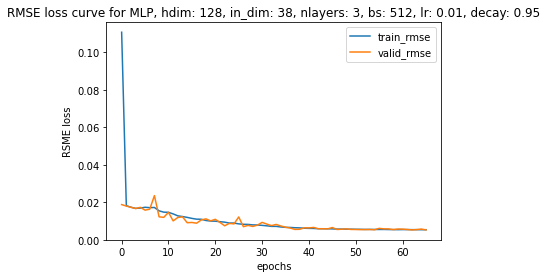

 44%|████▍     | 154/352 [01:39<01:35,  2.08it/s]


 88%|████████▊ | 308/352 [03:00<00:19,  2.25it/s]


100%|██████████| 352/352 [03:19<00:00,  1.77it/s]


Epoch 67 | T: 4.18 | Train RMSE: 0.00530 | Valid RMSE: 0.00529


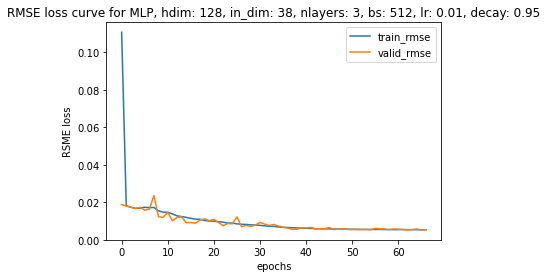

 44%|████▍     | 154/352 [01:46<01:33,  2.12it/s]


 88%|████████▊ | 308/352 [03:01<00:19,  2.30it/s]


100%|██████████| 352/352 [03:40<00:00,  1.59it/s]


Epoch 68 | T: 4.05 | Train RMSE: 0.00531 | Valid RMSE: 0.00519


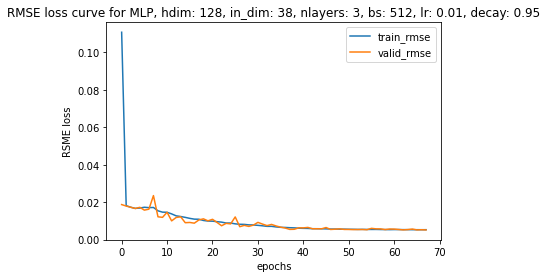

 44%|████▍     | 154/352 [02:00<01:26,  2.28it/s]


 88%|████████▊ | 308/352 [03:30<00:24,  1.83it/s]


100%|██████████| 352/352 [03:49<00:00,  1.54it/s]


Epoch 69 | T: 4.18 | Train RMSE: 0.00530 | Valid RMSE: 0.00519


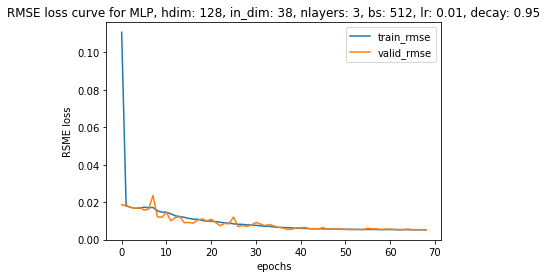

 44%|████▍     | 154/352 [02:18<01:29,  2.21it/s]


 88%|████████▊ | 308/352 [03:37<00:20,  2.15it/s]


100%|██████████| 352/352 [03:55<00:00,  1.49it/s]


Epoch 70 | T: 4.73 | Train RMSE: 0.00527 | Valid RMSE: 0.00529


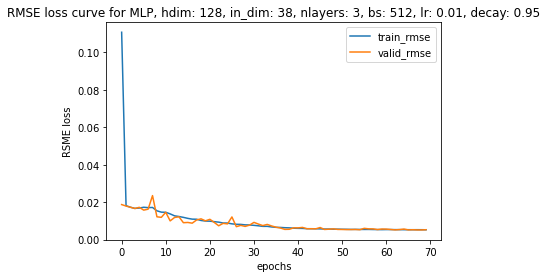

 44%|████▍     | 154/352 [01:54<01:21,  2.44it/s]


 88%|████████▊ | 308/352 [03:07<00:19,  2.25it/s]


100%|██████████| 352/352 [03:45<00:00,  1.56it/s]


Epoch 71 | T: 4.13 | Train RMSE: 0.00529 | Valid RMSE: 0.00522


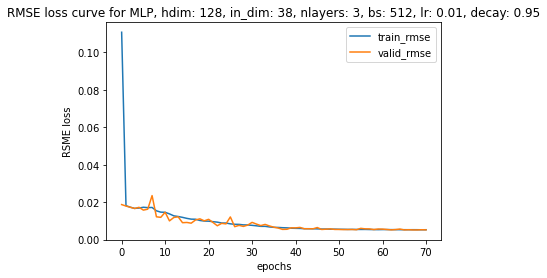

 44%|████▍     | 154/352 [02:06<01:28,  2.23it/s]


 88%|████████▊ | 308/352 [03:33<00:20,  2.11it/s]


100%|██████████| 352/352 [03:52<00:00,  1.51it/s]


Epoch 72 | T: 4.80 | Train RMSE: 0.00528 | Valid RMSE: 0.00521


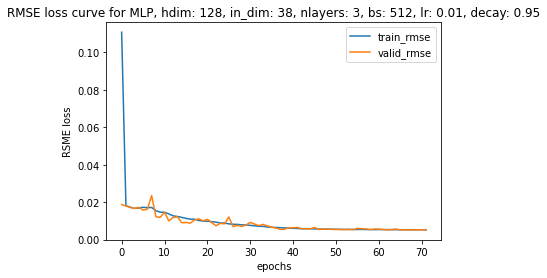

 44%|████▍     | 154/352 [01:45<01:34,  2.09it/s]


 88%|████████▊ | 308/352 [03:04<00:21,  2.03it/s]


100%|██████████| 352/352 [03:46<00:00,  1.55it/s]


Epoch 73 | T: 4.18 | Train RMSE: 0.00528 | Valid RMSE: 0.00523


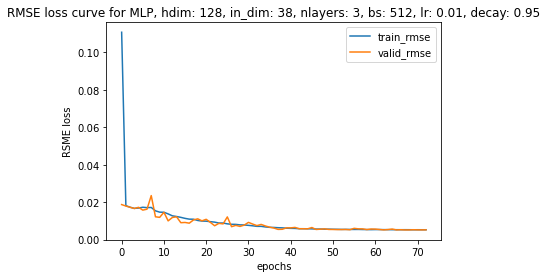

 44%|████▍     | 154/352 [01:58<01:34,  2.10it/s]


 88%|████████▊ | 308/352 [03:32<00:24,  1.83it/s]


100%|██████████| 352/352 [03:52<00:00,  1.52it/s]


Epoch 74 | T: 4.75 | Train RMSE: 0.00526 | Valid RMSE: 0.00520


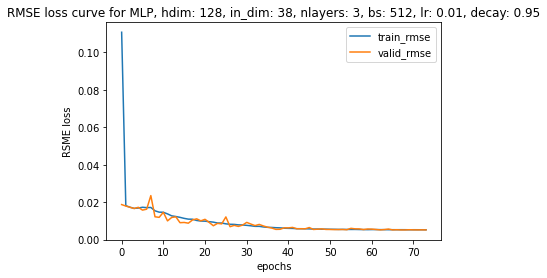

 44%|████▍     | 154/352 [01:46<01:38,  2.00it/s]


 88%|████████▊ | 308/352 [03:07<00:19,  2.21it/s]


100%|██████████| 352/352 [03:47<00:00,  1.55it/s]


Epoch 75 | T: 4.19 | Train RMSE: 0.00525 | Valid RMSE: 0.00533


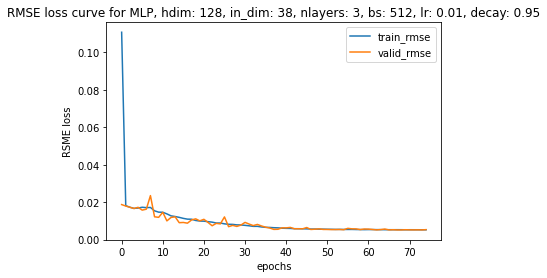

 44%|████▍     | 154/352 [01:59<01:34,  2.10it/s]


 88%|████████▊ | 308/352 [03:31<02:33,  3.49s/it]


100%|██████████| 352/352 [03:51<00:00,  1.52it/s]


Epoch 76 | T: 4.24 | Train RMSE: 0.00526 | Valid RMSE: 0.00534


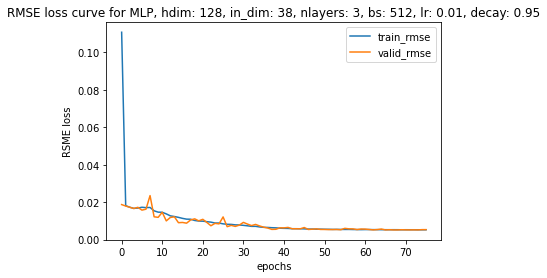

 44%|████▍     | 154/352 [02:15<01:35,  2.07it/s]


 88%|████████▊ | 308/352 [03:36<00:18,  2.42it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


Epoch 77 | T: 4.69 | Train RMSE: 0.00526 | Valid RMSE: 0.00520


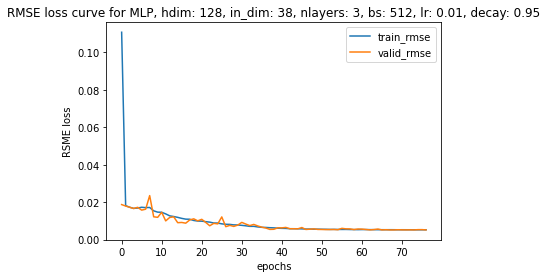

 44%|████▍     | 154/352 [02:00<01:37,  2.04it/s]


 88%|████████▊ | 308/352 [03:17<00:20,  2.18it/s]


100%|██████████| 352/352 [03:52<00:00,  1.51it/s]


Epoch 78 | T: 4.28 | Train RMSE: 0.00525 | Valid RMSE: 0.00519


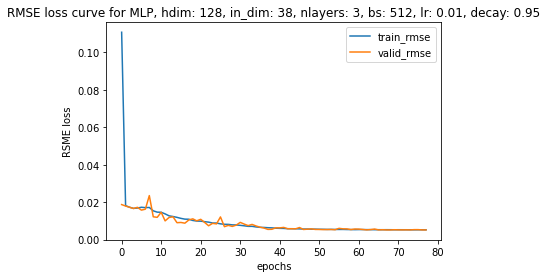

 44%|████▍     | 154/352 [02:13<02:20,  1.41it/s]


 88%|████████▊ | 308/352 [03:36<00:21,  2.02it/s]


100%|██████████| 352/352 [03:55<00:00,  1.49it/s]


Epoch 79 | T: 4.68 | Train RMSE: 0.00525 | Valid RMSE: 0.00519


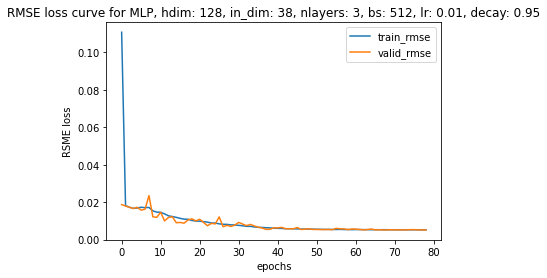

 44%|████▍     | 154/352 [01:59<01:30,  2.18it/s]


 88%|████████▊ | 308/352 [03:16<00:19,  2.26it/s]


100%|██████████| 352/352 [03:53<00:00,  1.51it/s]


Epoch 80 | T: 4.28 | Train RMSE: 0.00526 | Valid RMSE: 0.00519


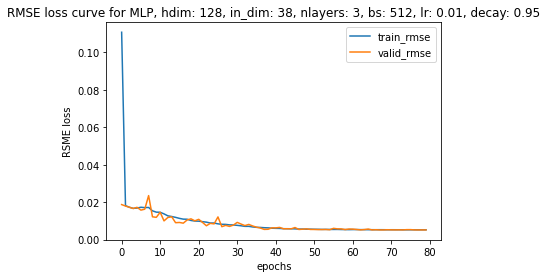

 44%|████▍     | 154/352 [02:07<01:31,  2.16it/s]


 88%|████████▊ | 308/352 [03:37<00:20,  2.12it/s]


100%|██████████| 352/352 [03:57<00:00,  1.48it/s]


Epoch 81 | T: 4.68 | Train RMSE: 0.00524 | Valid RMSE: 0.00522


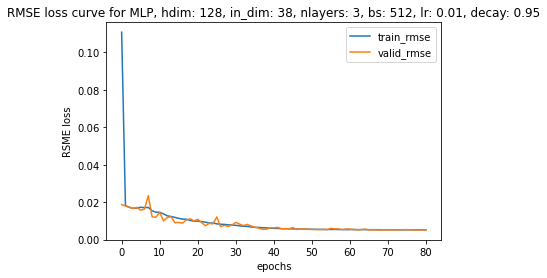

 44%|████▍     | 154/352 [02:01<01:34,  2.09it/s]


 88%|████████▊ | 308/352 [03:19<00:20,  2.13it/s]


100%|██████████| 352/352 [03:53<00:00,  1.51it/s]


Epoch 82 | T: 4.26 | Train RMSE: 0.00523 | Valid RMSE: 0.00518


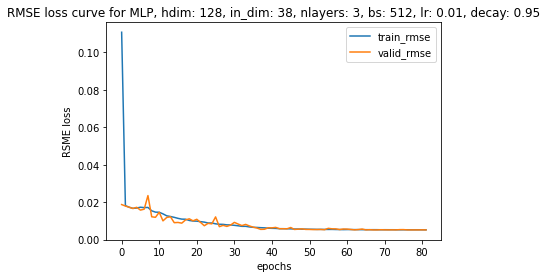

 44%|████▍     | 154/352 [02:10<01:38,  2.01it/s]


 88%|████████▊ | 308/352 [03:37<00:19,  2.22it/s]


100%|██████████| 352/352 [03:57<00:00,  1.48it/s]


Epoch 83 | T: 4.67 | Train RMSE: 0.00523 | Valid RMSE: 0.00525


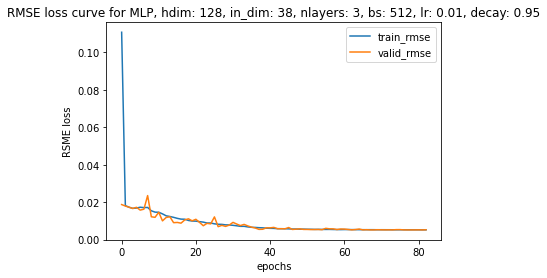

 44%|████▍     | 154/352 [02:01<01:35,  2.06it/s]


 88%|████████▊ | 308/352 [03:18<00:20,  2.19it/s]


100%|██████████| 352/352 [03:55<00:00,  1.50it/s]


Epoch 84 | T: 4.32 | Train RMSE: 0.00523 | Valid RMSE: 0.00523


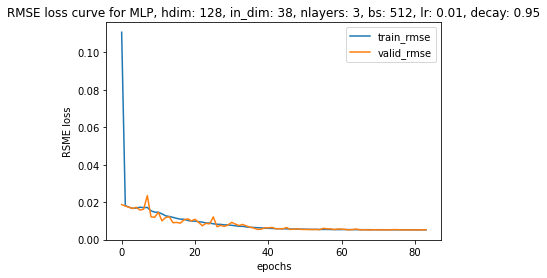

 44%|████▍     | 154/352 [02:05<01:31,  2.16it/s]


 88%|████████▊ | 308/352 [03:35<00:21,  2.02it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


Epoch 85 | T: 4.62 | Train RMSE: 0.00523 | Valid RMSE: 0.00518


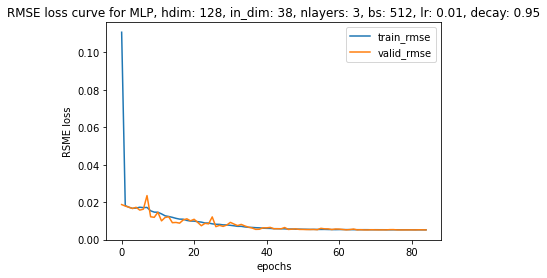

 44%|████▍     | 154/352 [02:00<01:42,  1.93it/s]


 88%|████████▊ | 308/352 [03:17<00:18,  2.38it/s]


100%|██████████| 352/352 [03:52<00:00,  1.52it/s]


Epoch 86 | T: 4.27 | Train RMSE: 0.00523 | Valid RMSE: 0.00526


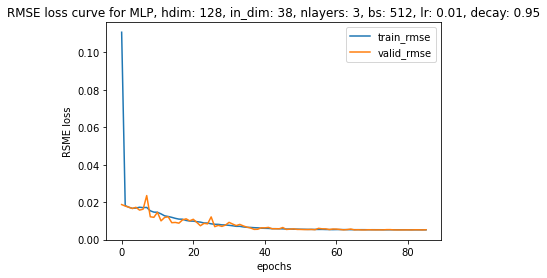

 44%|████▍     | 154/352 [02:07<01:32,  2.14it/s]


 88%|████████▊ | 308/352 [03:34<00:28,  1.55it/s]


100%|██████████| 352/352 [03:55<00:00,  1.50it/s]


Epoch 87 | T: 4.30 | Train RMSE: 0.00522 | Valid RMSE: 0.00521


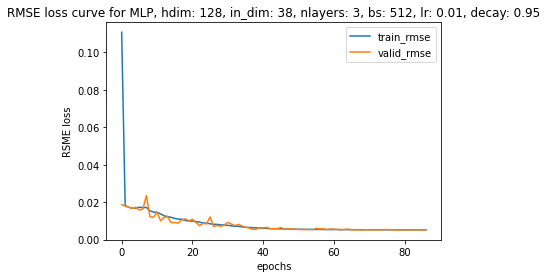

 44%|████▍     | 154/352 [02:20<03:10,  1.04it/s]


 88%|████████▊ | 308/352 [03:37<00:21,  2.06it/s]


100%|██████████| 352/352 [03:57<00:00,  1.48it/s]


Epoch 88 | T: 4.61 | Train RMSE: 0.00522 | Valid RMSE: 0.00520


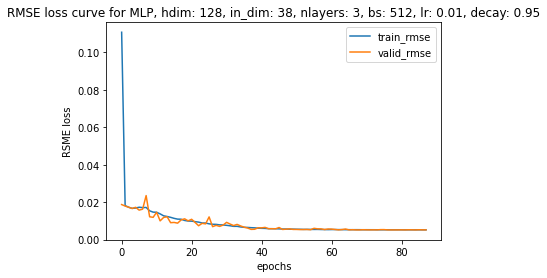

 44%|████▍     | 154/352 [02:06<01:40,  1.97it/s]


 88%|████████▊ | 308/352 [03:23<00:20,  2.13it/s]


100%|██████████| 352/352 [03:54<00:00,  1.50it/s]


Epoch 89 | T: 4.30 | Train RMSE: 0.00523 | Valid RMSE: 0.00529


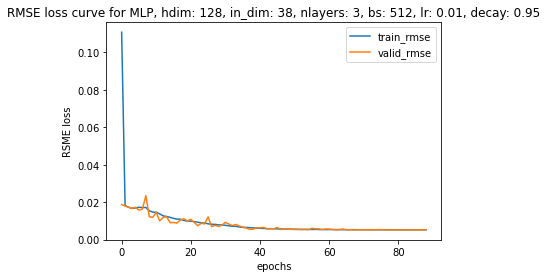

 44%|████▍     | 154/352 [02:06<01:35,  2.08it/s]


 88%|████████▊ | 308/352 [03:37<00:21,  2.04it/s]


100%|██████████| 352/352 [03:58<00:00,  1.48it/s]


Epoch 90 | T: 4.64 | Train RMSE: 0.00521 | Valid RMSE: 0.00526


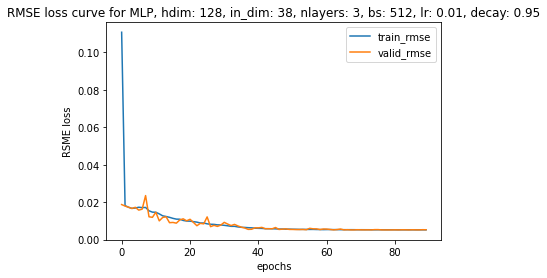

 44%|████▍     | 154/352 [02:03<01:40,  1.96it/s]


 88%|████████▊ | 308/352 [03:23<00:21,  2.07it/s]


100%|██████████| 352/352 [03:54<00:00,  1.50it/s]


Epoch 91 | T: 4.31 | Train RMSE: 0.00521 | Valid RMSE: 0.00525


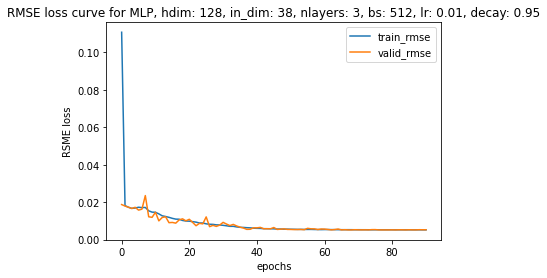

 44%|████▍     | 154/352 [02:02<01:37,  2.03it/s]


 88%|████████▊ | 308/352 [03:36<00:21,  2.08it/s]


100%|██████████| 352/352 [03:57<00:00,  1.48it/s]


Epoch 92 | T: 4.61 | Train RMSE: 0.00521 | Valid RMSE: 0.00525


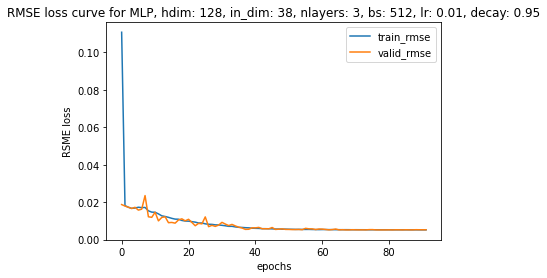

 44%|████▍     | 154/352 [01:37<01:24,  2.34it/s]


 88%|████████▊ | 308/352 [03:26<00:20,  2.16it/s]


100%|██████████| 352/352 [03:54<00:00,  1.50it/s]


Epoch 93 | T: 4.31 | Train RMSE: 0.00521 | Valid RMSE: 0.00521


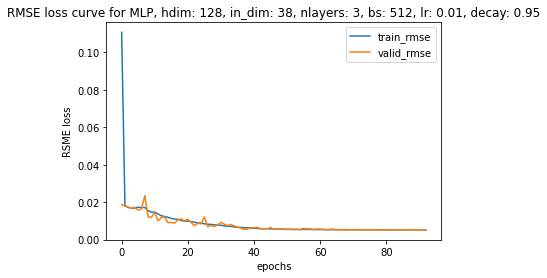

 44%|████▍     | 154/352 [02:02<01:36,  2.05it/s]


 88%|████████▊ | 308/352 [03:34<00:21,  2.04it/s]


100%|██████████| 352/352 [03:55<00:00,  1.49it/s]


Epoch 94 | T: 4.30 | Train RMSE: 0.00522 | Valid RMSE: 0.00518


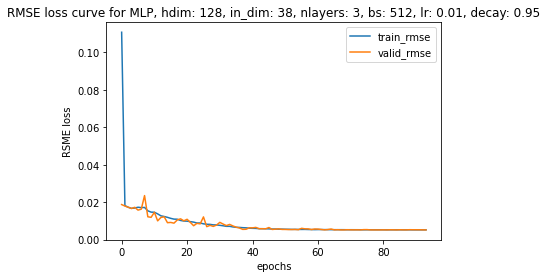

 44%|████▍     | 154/352 [01:55<01:35,  2.08it/s]


 88%|████████▊ | 308/352 [03:40<00:21,  2.04it/s]


100%|██████████| 352/352 [04:01<00:00,  1.46it/s]


Epoch 95 | T: 4.60 | Train RMSE: 0.00521 | Valid RMSE: 0.00521


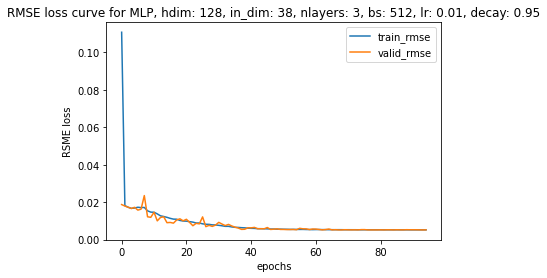

 44%|████▍     | 154/352 [01:59<01:37,  2.04it/s]


 88%|████████▊ | 308/352 [03:24<00:21,  2.02it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


Epoch 96 | T: 4.32 | Train RMSE: 0.00521 | Valid RMSE: 0.00518


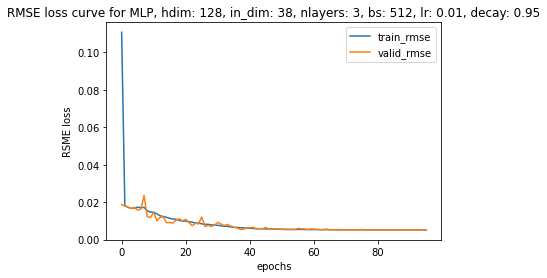

 44%|████▍     | 154/352 [01:51<01:34,  2.09it/s]


 88%|████████▊ | 308/352 [03:22<00:25,  1.69it/s]


100%|██████████| 352/352 [03:46<00:00,  1.56it/s]


Epoch 97 | T: 4.19 | Train RMSE: 0.00521 | Valid RMSE: 0.00518


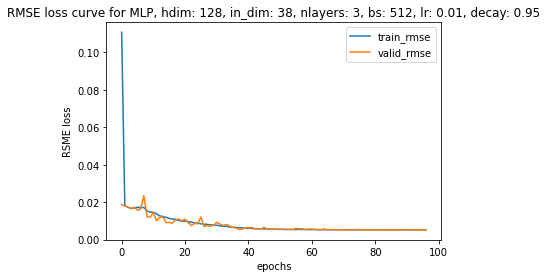

 44%|████▍     | 154/352 [01:28<01:46,  1.86it/s]


 88%|████████▊ | 308/352 [02:51<00:23,  1.83it/s]


100%|██████████| 352/352 [03:15<00:00,  1.80it/s]


Epoch 98 | T: 3.69 | Train RMSE: 0.00521 | Valid RMSE: 0.00520


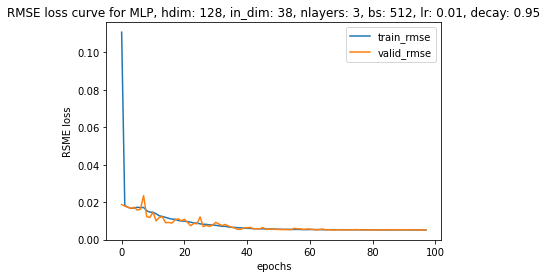

 44%|████▍     | 154/352 [01:26<02:24,  1.37it/s]


 88%|████████▊ | 308/352 [02:47<00:24,  1.83it/s]


100%|██████████| 352/352 [03:11<00:00,  1.84it/s]


Epoch 99 | T: 3.59 | Train RMSE: 0.00520 | Valid RMSE: 0.00519


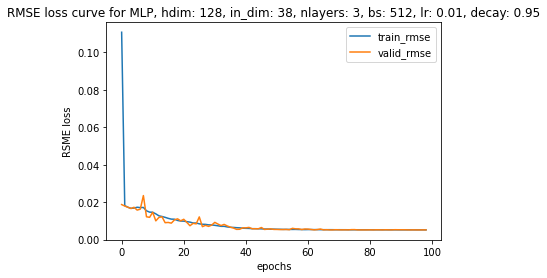

 44%|████▍     | 154/352 [01:22<01:27,  2.26it/s]


 88%|████████▊ | 308/352 [02:41<00:23,  1.86it/s]


100%|██████████| 352/352 [03:04<00:00,  1.91it/s]


Epoch 100 | T: 3.49 | Train RMSE: 0.00520 | Valid RMSE: 0.00518


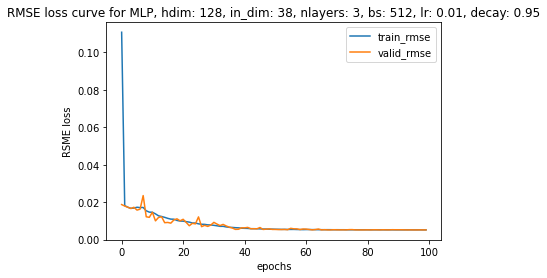

 44%|████▍     | 154/352 [01:26<02:00,  1.64it/s]


 88%|████████▊ | 308/352 [02:46<00:23,  1.90it/s]


100%|██████████| 352/352 [03:10<00:00,  1.85it/s]


Epoch 101 | T: 3.56 | Train RMSE: 0.00520 | Valid RMSE: 0.00518


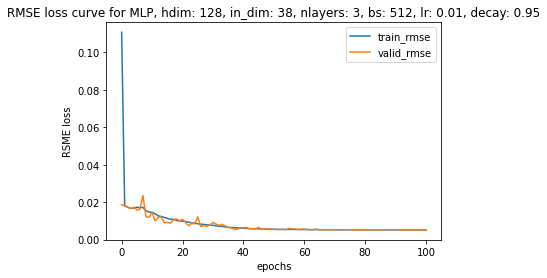

 44%|████▍     | 154/352 [01:24<01:43,  1.91it/s]


 88%|████████▊ | 308/352 [02:46<00:23,  1.85it/s]


 10%|█         | 101/1000 [7:20:44<65:23:00, 261.83s/it]


In [34]:
train_rmse = []
valid_rmse = []
min_rmse = 10e8

for i in tqdm(range(num_epoch)):
    start = time.time()

    # model.train() # if you use dropout or batchnorm. 
    train_rmse.append(train_epoch(train_loader, model, optimizer, loss_fun))
    #print(train_rmse)
    
    # model.eval()
    val_rmse, val_preds, val_trues = eval_epoch(valid_loader, model, loss_fun)
    valid_rmse.append(val_rmse)

    # save the best model
    if valid_rmse[-1] < min_rmse:
        min_rmse = valid_rmse[-1] 
        best_model = model
        # torch.save([best_model, i, get_lr(optimizer)], name + ".pth")

    end = time.time()
    
    # Early Stopping
    if (len(train_rmse) > 100 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
            break       

    # Learning Rate Decay        
    scheduler.step()
    
    print("Epoch {} | T: {:0.2f} | Train RMSE: {:0.5f} | Valid RMSE: {:0.5f}".format(i + 1, (end-start) / 60, train_rmse[-1], valid_rmse[-1]))

    plt.figure()
    plt.plot(train_rmse, label="train_rmse")
    plt.plot(valid_rmse, label="valid_rmse")
    plt.xlabel('epochs')
    plt.ylabel('RSME loss')
    plt.title(f'RMSE loss curve for MLP, hdim: {hidden_dim}, in_dim: {in_dim}, nlayers: {num_layers}, bs: {batch_size}, lr: {learning_rate}, decay: {decay_rate}')
    plt.legend()
    plt.savefig(f'mlp_loss_curve_v1_hdim_{hidden_dim}_indim_{in_dim}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}.png')
    plt.show()
    
# torch.save(model.state_dict(), 'baseline.pt')

# plt.figure()
# plt.plot(train_rmse)
# plt.plot(valid_rmse)
# plt.xlabel('epochs')
# plt.ylabel('RSME loss')
# plt.savefig('loss_curve.png')
# plt.show()

In [41]:
train_rmse

[0.11066,
 0.01812,
 0.01729,
 0.01668,
 0.01686,
 0.01728,
 0.01708,
 0.01717,
 0.01538,
 0.01467,
 0.0146,
 0.01374,
 0.0127,
 0.01234,
 0.01189,
 0.01135,
 0.01094,
 0.01089,
 0.01023,
 0.00992,
 0.00986,
 0.00959,
 0.00934,
 0.00887,
 0.00886,
 0.00843,
 0.00819,
 0.00814,
 0.00788,
 0.00783,
 0.00763,
 0.00739,
 0.00709,
 0.0071,
 0.00677,
 0.00657,
 0.00651,
 0.00637,
 0.00629,
 0.0061,
 0.00603,
 0.00599,
 0.00584,
 0.00583,
 0.0058,
 0.00575,
 0.00565,
 0.00565,
 0.00558,
 0.0056,
 0.00554,
 0.00552,
 0.00546,
 0.00548,
 0.00544,
 0.00544,
 0.00545,
 0.0054,
 0.00537,
 0.00534,
 0.00538,
 0.00538,
 0.00535,
 0.00534,
 0.00531,
 0.00531,
 0.0053,
 0.00531,
 0.0053,
 0.00527,
 0.00529,
 0.00528,
 0.00528,
 0.00526,
 0.00525,
 0.00526,
 0.00526,
 0.00525,
 0.00525,
 0.00526,
 0.00524,
 0.00523,
 0.00523,
 0.00523,
 0.00523,
 0.00523,
 0.00522,
 0.00522,
 0.00523,
 0.00521,
 0.00521,
 0.00521,
 0.00521,
 0.00522,
 0.00521,
 0.00521,
 0.00521,
 0.00521,
 0.0052,
 0.0052,
 0.0052,
 0

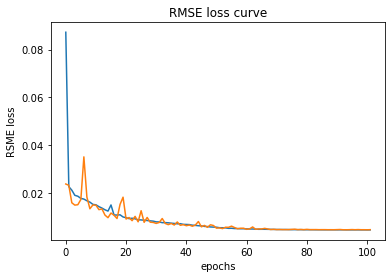

In [24]:
plt.figure()
plt.plot(train_rmse)
plt.plot(valid_rmse)
plt.xlabel('epochs')
plt.ylabel('RSME loss')
plt.title('RMSE loss curve')
plt.savefig('loss_curve_v1.png')
plt.show()

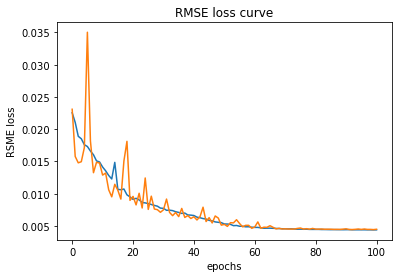

In [25]:
plt.figure()
plt.plot(train_rmse[1:])
plt.plot(valid_rmse[1:])
plt.xlabel('epochs')
plt.ylabel('RSME loss')
plt.title('RMSE loss curve')
plt.savefig('loss_curve_v2.png')
plt.show()

# Evaluation and Submission

In [9]:
model.load_state_dict(torch.load('baseline_mlp.pt'))

<All keys matched successfully>

In [10]:
best_model = model

In [46]:
test_path = "../val_in/val_in/"
test_pkl_list = glob(os.path.join(test_path, '*'))
test_pkl_list.sort()

test_preds = []
for idx in range(len(test_pkl_list)):
    with open(test_pkl_list[idx], 'rb') as f:
        test_sample = pickle.load(f)
        pred_id = np.where(test_sample["track_id"] == test_sample['agent_id'])[0][0]
        inp_scene = np.dstack([test_sample['p_in'], test_sample['v_in']])

        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        inp = torch.from_numpy(inp).float().to(device).unsqueeze(0)

        preds = best_model(inp).cpu().data.numpy()
        
        # De-Normalization ! 
        preds = preds * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
        test_preds.append(preds)

In [47]:
print(len(test_preds))
print(test_preds[0])

3200
[[[1715.32064837  336.71825627]
  [1715.99695175  337.58026029]
  [1716.76575262  338.39678201]
  [1718.14010514  339.20117511]
  [1718.82421202  340.05951437]
  [1719.77103676  340.84085002]
  [1720.01336146  341.77036852]
  [1720.95175842  342.63494659]
  [1721.91366992  343.49832489]
  [1722.57051657  344.25387634]
  [1723.38894771  345.11817083]
  [1724.25107845  345.91220226]
  [1724.69161207  346.85633617]
  [1725.9389236   347.65992216]
  [1726.56341174  348.43912004]
  [1727.25854757  349.22704353]
  [1728.60179013  350.10484092]
  [1729.04284398  350.88571848]
  [1730.17684868  351.69170401]
  [1730.79956803  352.62146247]
  [1732.13323829  353.46682236]
  [1732.13323829  354.39317782]
  [1732.96269838  355.02589435]
  [1734.00274893  355.920554  ]
  [1734.68997722  356.81218149]
  [1736.32642331  357.59537134]
  [1736.52432008  358.40920993]
  [1737.92738948  359.17324704]
  [1738.10010696  360.00141746]
  [1738.5244093   360.8201424 ]]]


# Generate Submission File

In [48]:
# Submission Files
sample_sub = pd.read_csv('sample_submission.csv')

In [16]:
# Convert to int
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1).astype(int)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df.to_csv('test_submission.csv', index=None)

In [49]:
# Convert to float (Attempt 2) and save for later use
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df["ID"] = sub_df["ID"].astype(int)
sub_df.to_csv(f'test_submission_mlp_hdim_{hidden_dim}_indim_{in_dim}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}.csv', index=None)

In [50]:
# Convert to float
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df["ID"] = sub_df["ID"].astype(int)
sub_df.to_csv('test_submission.csv', index=None)

In [51]:
sub_df

ID           v1           v2           v3           v4           v5  \
0     10002  1715.320648   336.718256  1715.996952   337.580260  1716.765753   
1     10015   726.279695  1229.549519   726.240434  1229.295355   726.199070   
2     10019   574.657705  1245.933727   574.913028  1245.843043   575.110307   
3     10028  1692.280308   315.564668  1692.833774   316.135499  1693.447303   
4      1003  2124.327821   677.480243  2123.065302   676.478406  2121.915393   
...     ...          ...          ...          ...          ...          ...   
3195   9897   256.445808   806.151395   256.643717   805.994235   256.799741   
3196     99   588.367779  1154.993743   588.417095  1154.445948   588.428571   
3197   9905  1756.128443   444.251098  1755.766851   444.654964  1755.547268   
3198   9910   575.308508  1289.595515   575.310078  1289.376130   575.179220   
3199   9918   585.322745  1164.651871   585.468714  1163.607246   585.497063   

               v6           v7           v8           v9  ...          v51  \
0      338.396782  1718.140105   339.201175  1718.824212  ...  1736.326423   
1     1228.869784   726.232153  1228.523868   726.162899  ...   726.149156   
2     1245.648079   575.169634  1245.654523   575.370410  ...   579.959358   
3      316.645141  1693.904023   317.193058  1694.502234  ...  1705.772704   
4      675.333170  2120.758319   674.232891  2119.520753  ...  2095.631294   
...           ...          ...          ...          ...  ...          ...   
3195   805.807236   257.016619   805.692938   257.170605  ...   261.143410   
3196  1153.772815   588.435688  1153.219294   588.438485  ...   589.233565   
3197   444.959339  1755.968670   445.257305  1755.629993  ...  1752.347389   
3198  1289.107782   575.143327  1289.043627   575.012207  ...   573.866970   
3199  1162.477335   585.703419  1161.497523   585.721568  ...   588.188452   

              v52          v53          v54          v55          v56  \
0      357.595371  1736.524320   358.409210  1737.927389   359.173247   
1     1221.456987   726.119252  1221.189454   726.133398  1220.881735   
2     1242.427288   580.371398  1242.462021   580.390020  1242.512000   
3      328.899914  1706.267921   329.423003  1706.683726   329.953717   
4      650.844862  2094.388994   649.787795  2093.212340   648.766909   
...           ...          ...          ...          ...          ...   
3195   802.067564   261.313407   801.929551   261.521600   801.762720   
3196  1139.976422   589.309282  1139.431172   589.294720  1138.911512   
3197   453.078699  1751.489554   453.390493  1751.890564   453.671439   
3198  1284.015709   573.861997  1283.918414   573.799484  1283.813090   
3199  1138.198434   588.255394  1137.198642   588.440569  1136.225890   

              v57          v58          v59          v60  
0     1738.100107   360.001417  1738.524409   360.820142  
1      726.095078  1220.566376   726.107523  1220.331309  
2      580.767848  1242.051034   581.146746  1241.956420  
3     1707.226308   330.459603  1707.693308   330.955235  
4     2092.078427   647.841263  2090.892304   646.819754  
...           ...          ...          ...          ...  
3195   261.653432   801.517941   261.829783   801.479842  
3196   589.348575  1138.261355   589.420805  1137.743180  
3197  1751.119133   454.121018  1750.482668   454.462430  
3198   573.729718  1283.337322   573.721119  1283.317643  
3199   588.464945  1135.122243   588.533566  1134.309334  

[3200 rows x 61 columns]

In [ ]:
# Ensemble Method 